In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from imblearn.over_sampling import SMOTE

gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("GPU 환경에서 실행됩니다.")
else:
    print("GPU가 감지되지 않습니다. CPU 환경에서 실행됩니다.")

GPU가 감지되지 않습니다. CPU 환경에서 실행됩니다.


In [116]:
import os
base_dir = os.getcwd()
train_path = os.path.join(base_dir, "데이터셋", "train.csv")
test_path = os.path.join(base_dir, "데이터셋", "test.csv")

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.head()

,UID,주거 형태,연간 소득,현재 직장 근속 연수,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,개인 파산 횟수,대출 목적,대출 상환 기간,현재 대출 잔액,현재 미상환 신용액,월 상환 부채액,신용 점수,채무 불이행 여부
0,TRAIN_00000,자가,1941337.5,10년 이상,0.0,9,13.4,400597.5,0,24,1,부채 통합,단기 상환,390903.0,225457.5,8806.5,767,0
1,TRAIN_00001,월세,1979505.0,10년 이상,0.0,5,15.1,360679.5,0,11,0,부채 통합,단기 상환,1002184.5,64749.0,24961.5,767,0
2,TRAIN_00002,월세,1356381.0,4년,0.0,12,18.8,491770.5,1,74,3,부채 통합,단기 상환,227775.0,487644.0,12069.0,800,1
3,TRAIN_00003,월세,1049017.5,6년,0.0,15,14.8,411546.0,1,22,1,부채 통합,단기 상환,251383.5,413211.0,31749.0,796,1
4,TRAIN_00004,월세,4320217.5,2년,0.0,11,26.1,895288.5,0,32,0,부채 통합,장기 상환,1163176.5,78991.5,5862.0,751,0


<Axes: xlabel='대출 상환 기간', ylabel='count'>

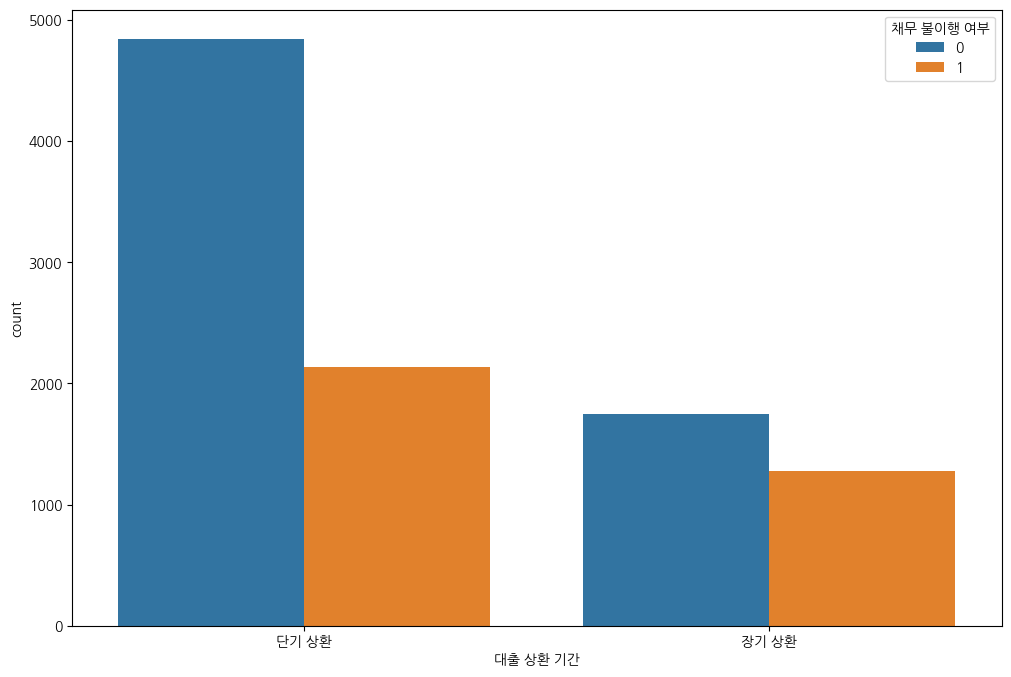

In [117]:
import matplotlib.font_manager as fm


plt.rc('font', family='NanumGothic')  # 폰트 변경
plt.rc('axes', unicode_minus=False)  # 마이너스 기호 깨짐 방지

plt.figure(figsize = (12,8))
sns.countplot(x = "대출 상환 기간", hue = "채무 불이행 여부", data = train_df)

In [118]:
def preprocess(df):
    df = df.copy()
    def year(x):
        return "".join(v.replace("이상", "").replace("년", "") for v in x.split(" "))

    def year1(x):
        return "".join(v.replace('1미만', "0") for v in x.split(" "))

 
    df["현재 직장 근속 연수"] = df["현재 직장 근속 연수"].apply(year)
    df["현재 직장 근속 연수"] = df["현재 직장 근속 연수"].apply(year1).astype(int)

    df["연간소득분위"] = pd.qcut(df["연간 소득"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["개설된_신용계좌_분위수"] = pd.qcut(df["개설된 신용계좌 수"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)

    df["위험분자1"] = ((df["개설된_신용계좌_분위수"] > 3) & (df["연간소득분위"] < 3)).astype(int)
    df["위험분자2"] = ((df["신용 문제 발생 횟수"] > 0) & (df["개인 파산 횟수"] > 0) | (df["체납 세금 압류 횟수"] > 0)).astype(int)

    df["신용거래분위"] = pd.qcut(df["신용 거래 연수"], 5, labels = [1,2,3,4,5], duplicates = "drop").astype(int)
    df["VIP"] = ((df["개설된_신용계좌_분위수"] > 3) & (df["신용거래분위"] > 3)).astype(int)
    


    
    df["신용 거래 연수"] = df["신용 거래 연수"].astype(int)
    df["신용한도vs대출잔액"] = (df["현재 대출 잔액"] +1 )  / (df["최대 신용한도"] + 1)* 100
    신용거래 = df.groupby("개설된 신용계좌 수")["신용 거래 연수"].agg("mean")
    df["신용거래연수_개설신용계좌"] = df["개설된 신용계좌 수"].map(신용거래)
    
    cols = (["주거 형태","대출 목적", "대출 상환 기간"])
    for c in cols:
        lb = LabelEncoder()
        lb.fit(df[c].values)
        df[c] = lb.transform(list(df[c].values))
        df[c] = df[c].astype(int)
        
    bankcount_purpose = df.groupby("대출 목적")["개설된 신용계좌 수"].agg("median")
    purpose_bankcount = df.groupby("개설된 신용계좌 수")["연간 소득"].agg("median")
    df["목적별_개설된_신용계좌수_평균"] = df["대출 목적"].map(bankcount_purpose)
    df["계좌수별_소득"] = df["개설된 신용계좌 수"].map(purpose_bankcount)
    
    return df

train = preprocess(train_df)
test = preprocess(test_df)
train.head()

,UID,주거 형태,연간 소득,현재 직장 근속 연수,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,...,연간소득분위,개설된_신용계좌_분위수,위험분자1,위험분자2,신용거래분위,VIP,신용한도vs대출잔액,신용거래연수_개설신용계좌,목적별_개설된_신용계좌수_평균,계좌수별_소득
0,TRAIN_00000,1,1941337.5,10,0.0,9,13,400597.5,0,24,...,3,2,0,0,1,0,97.579996,18.571922,12.0,1624296.00
1,TRAIN_00001,0,1979505.0,10,0.0,5,15,360679.5,0,11,...,3,1,0,0,2,0,277.859629,18.039216,12.0,1624805.25
2,TRAIN_00002,0,1356381.0,4,0.0,12,18,491770.5,1,74,...,2,3,0,1,3,0,46.317446,18.984709,12.0,1698640.50
3,TRAIN_00003,0,1049017.5,6,0.0,15,14,411546.0,1,22,...,1,4,1,1,2,0,61.082817,19.806630,12.0,1753455.00
4,TRAIN_00004,0,4320217.5,2,0.0,11,26,895288.5,0,32,...,5,2,0,0,5,0,129.921941,19.110526,12.0,1719634.50


In [119]:
target = train["채무 불이행 여부"]
uid = test["UID"]

train = train.drop(["채무 불이행 여부", "UID"], axis = 1)
test = test.drop("UID", axis = 1)

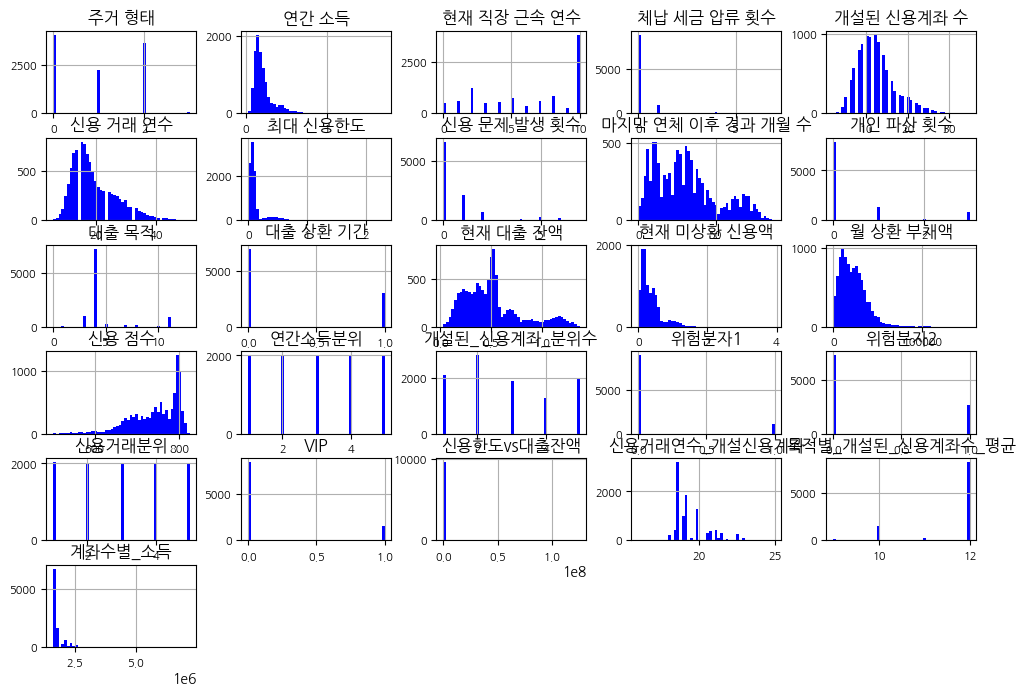

In [120]:
train.hist(figsize = (12,8), color = "b", bins = 50, xlabelsize = 8, ylabelsize = 8);

<Axes: ylabel='최대 신용한도'>

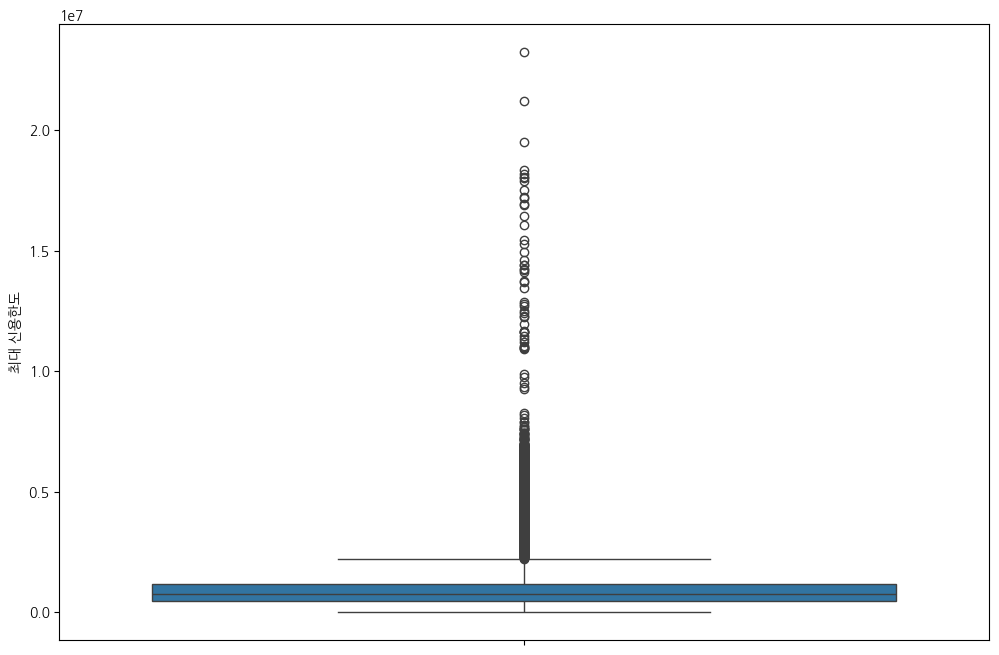

In [121]:
plt.figure(figsize = (12,8))
sns.boxplot(y = "최대 신용한도", data = train)

In [122]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   주거 형태              10000 non-null  int64  
 1   연간 소득              10000 non-null  float64
 2   현재 직장 근속 연수        10000 non-null  int64  
 3   체납 세금 압류 횟수        10000 non-null  float64
 4   개설된 신용계좌 수         10000 non-null  int64  
 5   신용 거래 연수           10000 non-null  int64  
 6   최대 신용한도            10000 non-null  float64
 7   신용 문제 발생 횟수        10000 non-null  int64  
 8   마지막 연체 이후 경과 개월 수  10000 non-null  int64  
 9   개인 파산 횟수           10000 non-null  int64  
 10  대출 목적              10000 non-null  int64  
 11  대출 상환 기간           10000 non-null  int64  
 12  현재 대출 잔액           10000 non-null  float64
 13  현재 미상환 신용액         10000 non-null  float64
 14  월 상환 부채액           10000 non-null  float64
 15  신용 점수              10000 non-null  int64  
 16  연간소득분위             1000

In [123]:
cols = ["최대 신용한도", "현재 대출 잔액", "현재 미상환 신용액", "연간 소득", "월 상환 부채액", "신용 점수", "신용한도vs대출잔액"]

In [124]:
for c in cols:
    train[c] = train[c].where((train[c] > 0), np.nan)
    train[c] = train[c].fillna(train[c].median())
    test[c] = test[c].where((test[c] > 0), np.nan)
    test[c] = test[c].fillna(test[c].median())

<Axes: >

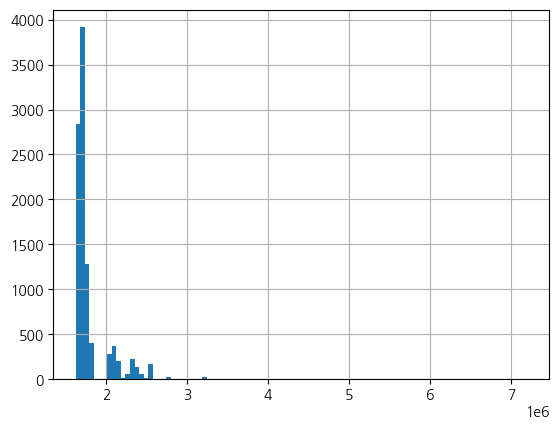

In [125]:
train["계좌수별_소득"].hist(bins = 100)

In [126]:
train["계좌수별_소득"] = np.log1p(train["계좌수별_소득"])

array([[<Axes: title={'center': '주거 형태'}>,
        <Axes: title={'center': '연간 소득'}>,
        <Axes: title={'center': '현재 직장 근속 연수'}>,
        <Axes: title={'center': '체납 세금 압류 횟수'}>,
        <Axes: title={'center': '개설된 신용계좌 수'}>],
       [<Axes: title={'center': '신용 거래 연수'}>,
        <Axes: title={'center': '최대 신용한도'}>,
        <Axes: title={'center': '신용 문제 발생 횟수'}>,
        <Axes: title={'center': '마지막 연체 이후 경과 개월 수'}>,
        <Axes: title={'center': '개인 파산 횟수'}>],
       [<Axes: title={'center': '대출 목적'}>,
        <Axes: title={'center': '대출 상환 기간'}>,
        <Axes: title={'center': '현재 대출 잔액'}>,
        <Axes: title={'center': '현재 미상환 신용액'}>,
        <Axes: title={'center': '월 상환 부채액'}>],
       [<Axes: title={'center': '신용 점수'}>,
        <Axes: title={'center': '연간소득분위'}>,
        <Axes: title={'center': '개설된_신용계좌_분위수'}>,
        <Axes: title={'center': '위험분자1'}>,
        <Axes: title={'center': '위험분자2'}>],
       [<Axes: title={'center': '신용거래분위'}>,
        <Axes: title={'cent

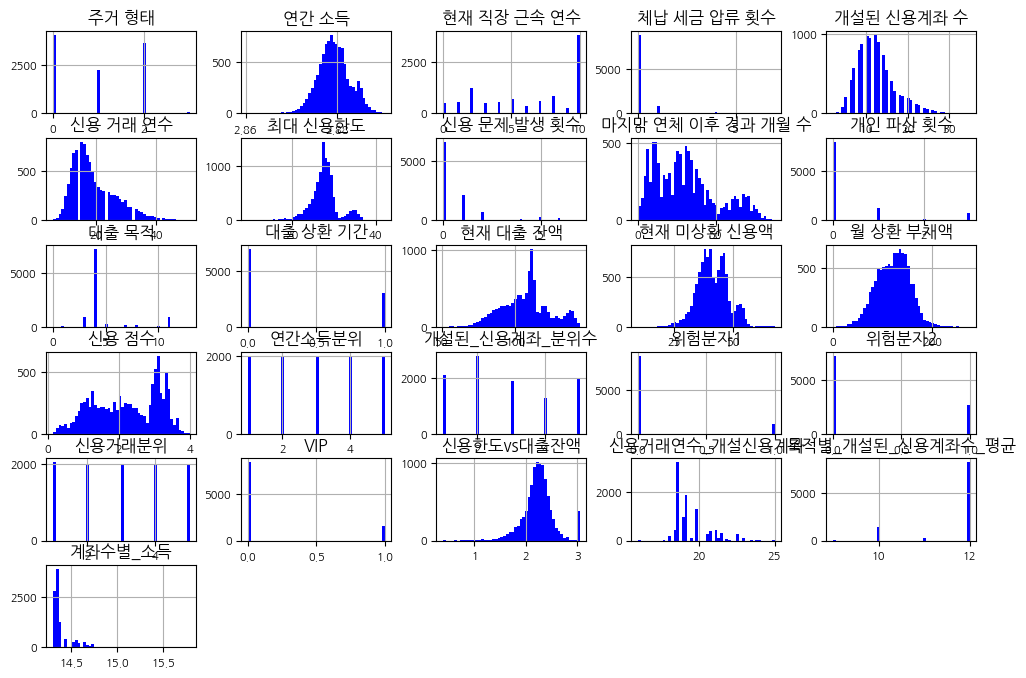

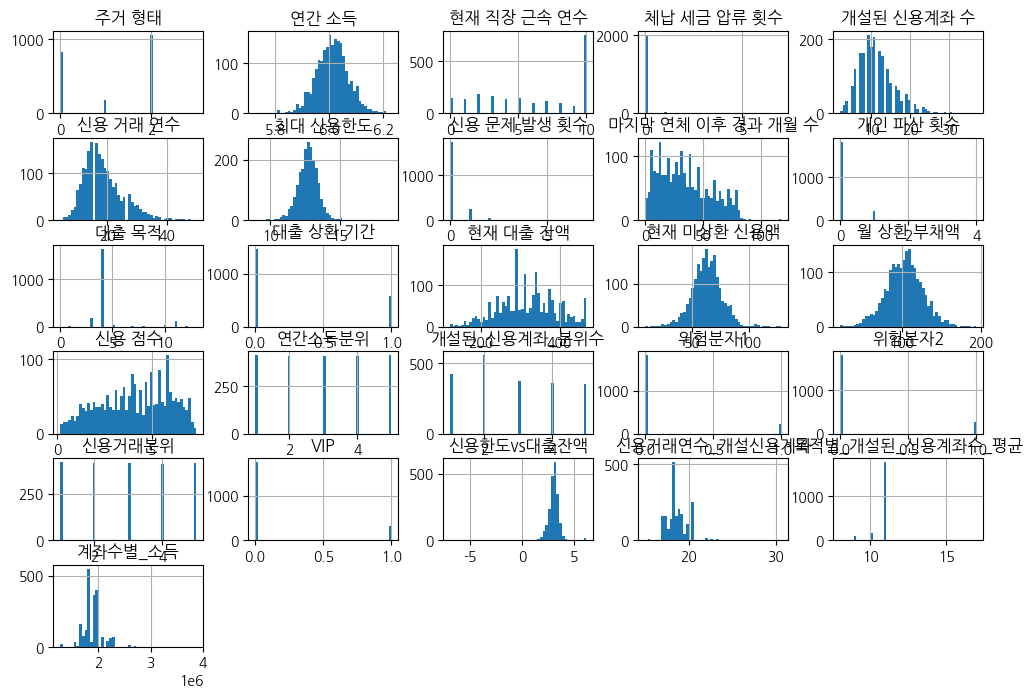

In [127]:
from scipy.stats import boxcox

cols = ["최대 신용한도", "현재 대출 잔액", "현재 미상환 신용액", "연간 소득", "월 상환 부채액", "신용 점수", "신용한도vs대출잔액"]

for c in cols:
    train[c], _= boxcox(train[c][train[c] > 0].values)
    test[c], _ = boxcox(test[c][test[c] > 0].values)
train.hist(figsize = (12,8), color = "b", bins = 50, xlabelsize = 8, ylabelsize = 8);
test.hist(figsize = (12,8), bins = 50)


<Axes: >

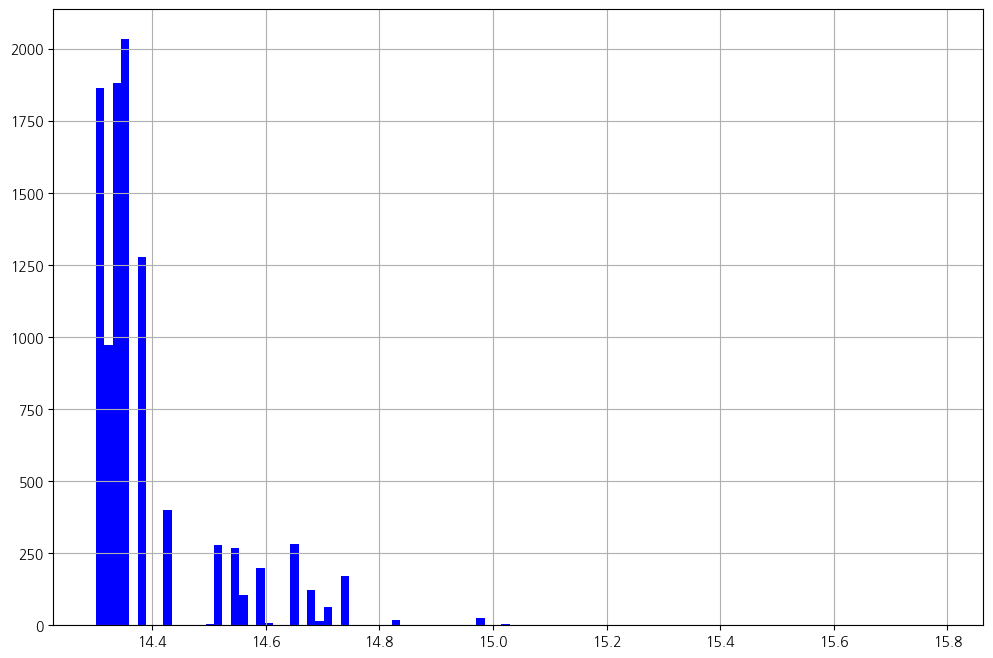

In [128]:
train["계좌수별_소득"].hist(figsize = (12,8), bins = 100, color = "b")

In [129]:
train.describe()

,주거 형태,연간 소득,현재 직장 근속 연수,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,개인 파산 횟수,...,연간소득분위,개설된_신용계좌_분위수,위험분자1,위험분자2,신용거래분위,VIP,신용한도vs대출잔액,신용거래연수_개설신용계좌,목적별_개설된_신용계좌수_평균,계좌수별_소득
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.973500,2.879252,6.430400,0.199300,12.248900,19.428800,27.687612,0.62620,30.889200,0.373200,...,3.000000,2.823600,0.108800,0.267500,2.991000,0.153000,2.235729,19.428800,11.654600,14.386531
std,0.893352,0.003492,3.536892,0.714304,4.620572,7.209517,3.441236,1.23419,20.011561,0.843797,...,1.414284,1.413253,0.311404,0.442677,1.417293,0.360006,0.295931,1.095765,0.759313,0.112267
min,0.000000,2.860570,0.000000,0.000000,2.000000,6.000000,9.454365,0.00000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.391119,16.000000,9.000000,14.300586
25%,0.000000,2.877004,3.000000,0.000000,9.000000,14.000000,26.055129,0.00000,14.000000,0.000000,...,2.000000,2.000000,0.000000,0.000000,2.000000,0.000000,2.092735,18.637205,12.000000,14.323956
50%,1.000000,2.879109,7.000000,0.000000,12.000000,17.500000,27.682038,0.00000,28.000000,0.000000,...,3.000000,3.000000,0.000000,0.000000,3.000000,0.000000,2.240853,19.110526,12.000000,14.345339
75%,2.000000,2.881363,10.000000,0.000000,15.000000,24.000000,29.031378,1.00000,41.000000,0.000000,...,4.000000,4.000000,0.000000,1.000000,4.000000,0.000000,2.378112,19.808163,12.000000,14.381269
max,3.000000,2.890255,10.000000,7.000000,35.000000,51.000000,42.084575,7.00000,88.000000,3.000000,...,5.000000,5.000000,1.000000,1.000000,5.000000,1.000000,3.040968,25.000000,12.000000,15.788943


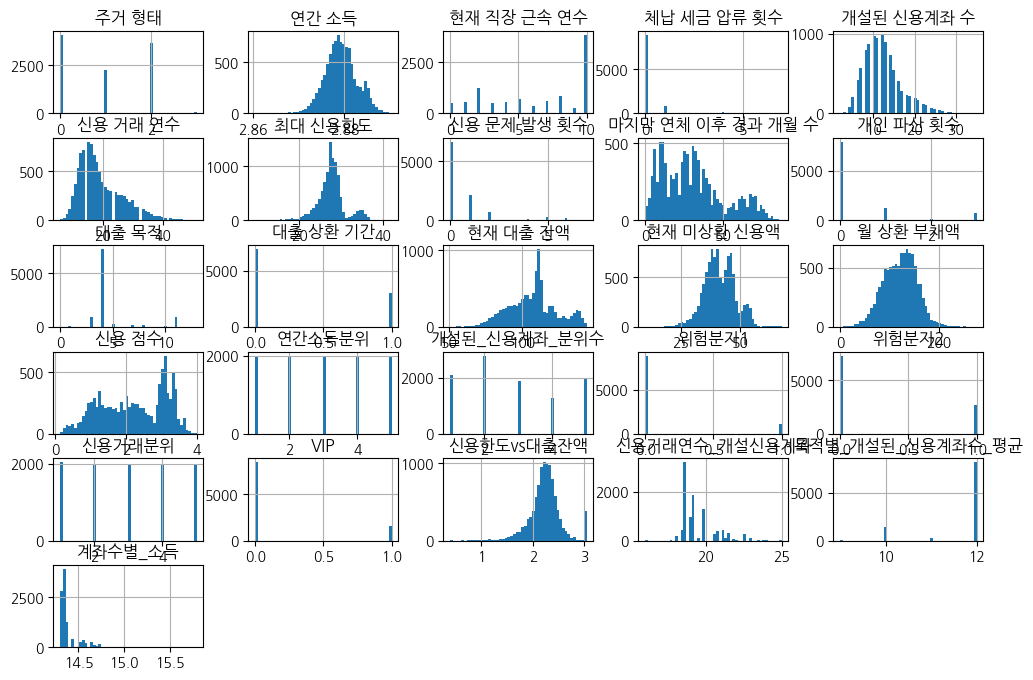

In [130]:
train.hist(figsize = (12, 8), bins = 50);

In [131]:
train.describe()

,주거 형태,연간 소득,현재 직장 근속 연수,체납 세금 압류 횟수,개설된 신용계좌 수,신용 거래 연수,최대 신용한도,신용 문제 발생 횟수,마지막 연체 이후 경과 개월 수,개인 파산 횟수,...,연간소득분위,개설된_신용계좌_분위수,위험분자1,위험분자2,신용거래분위,VIP,신용한도vs대출잔액,신용거래연수_개설신용계좌,목적별_개설된_신용계좌수_평균,계좌수별_소득
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.973500,2.879252,6.430400,0.199300,12.248900,19.428800,27.687612,0.62620,30.889200,0.373200,...,3.000000,2.823600,0.108800,0.267500,2.991000,0.153000,2.235729,19.428800,11.654600,14.386531
std,0.893352,0.003492,3.536892,0.714304,4.620572,7.209517,3.441236,1.23419,20.011561,0.843797,...,1.414284,1.413253,0.311404,0.442677,1.417293,0.360006,0.295931,1.095765,0.759313,0.112267
min,0.000000,2.860570,0.000000,0.000000,2.000000,6.000000,9.454365,0.00000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.391119,16.000000,9.000000,14.300586
25%,0.000000,2.877004,3.000000,0.000000,9.000000,14.000000,26.055129,0.00000,14.000000,0.000000,...,2.000000,2.000000,0.000000,0.000000,2.000000,0.000000,2.092735,18.637205,12.000000,14.323956
50%,1.000000,2.879109,7.000000,0.000000,12.000000,17.500000,27.682038,0.00000,28.000000,0.000000,...,3.000000,3.000000,0.000000,0.000000,3.000000,0.000000,2.240853,19.110526,12.000000,14.345339
75%,2.000000,2.881363,10.000000,0.000000,15.000000,24.000000,29.031378,1.00000,41.000000,0.000000,...,4.000000,4.000000,0.000000,1.000000,4.000000,0.000000,2.378112,19.808163,12.000000,14.381269
max,3.000000,2.890255,10.000000,7.000000,35.000000,51.000000,42.084575,7.00000,88.000000,3.000000,...,5.000000,5.000000,1.000000,1.000000,5.000000,1.000000,3.040968,25.000000,12.000000,15.788943


In [132]:
impute = SimpleImputer(strategy = "median")
X_imputed = impute.fit_transform(train)
test_imputed = impute.transform(test)

In [133]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)
test_scaled = scaler.transform(test_imputed)

In [134]:
smote = SMOTE(random_state = 42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, target)

Fold1 시작!
Epoch 1/100


C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4810 - loss: 0.7167 - val_accuracy: 0.4898 - val_loss: 0.6988
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4986 - loss: 0.7051 - val_accuracy: 0.5269 - val_loss: 0.6897
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5241 - loss: 0.6995 - val_accuracy: 0.5516 - val_loss: 0.6825
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5398 - loss: 0.6920 - val_accuracy: 0.5789 - val_loss: 0.6763
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5516 - loss: 0.6882 - val_accuracy: 0.5967 - val_loss: 0.6704
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5580 - loss: 0.6853 - val_accuracy: 0.6131 - val_loss: 0.6651
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5687 - loss: 0.6761 - val_accuracy: 0.6199 - val_loss: 0.6599
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5831 - loss: 0.6740 - val_accuracy: 0.6309

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4910 - loss: 0.7686 - val_accuracy: 0.4994 - val_loss: 0.7051
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5061 - loss: 0.7255 - val_accuracy: 0.5192 - val_loss: 0.6883
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5177 - loss: 0.7095 - val_accuracy: 0.5537 - val_loss: 0.6781
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5331 - loss: 0.6921 - val_accuracy: 0.5863 - val_loss: 0.6712
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5432 - loss: 0.6875 - val_accuracy: 0.6061 - val_loss: 0.6660
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5692 - loss: 0.6743 - val_accuracy: 0.6194 - val_loss: 0.6617
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5618 - loss: 0.6786 - val_accuracy: 0.6209 - val_loss: 0.6579
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5803 - loss: 0.6704 - val_accuracy: 0.6205

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5027 - loss: 0.7286 - val_accuracy: 0.5176 - val_loss: 0.7016
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5071 - loss: 0.7212 - val_accuracy: 0.5374 - val_loss: 0.6898
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5222 - loss: 0.7077 - val_accuracy: 0.5564 - val_loss: 0.6816
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5279 - loss: 0.6973 - val_accuracy: 0.5810 - val_loss: 0.6753
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5595 - loss: 0.6852 - val_accuracy: 0.5958 - val_loss: 0.6700
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5523 - loss: 0.6818 - val_accuracy: 0.6125 - val_loss: 0.6656
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5633 - loss: 0.6817 - val_accuracy: 0.6190 - val_loss: 0.6616
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5793 - loss: 0.6774 - val_accuracy: 0.6288

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5203 - loss: 0.7196 - val_accuracy: 0.5309 - val_loss: 0.6905
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5286 - loss: 0.7027 - val_accuracy: 0.5708 - val_loss: 0.6806
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5410 - loss: 0.6925 - val_accuracy: 0.5958 - val_loss: 0.6743
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5696 - loss: 0.6825 - val_accuracy: 0.6201 - val_loss: 0.6697
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5688 - loss: 0.6780 - val_accuracy: 0.6288 - val_loss: 0.6654
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5748 - loss: 0.6748 - val_accuracy: 0.6319 - val_loss: 0.6615
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5988 - loss: 0.6650 - val_accuracy: 0.6380 - val_loss: 0.6578
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5922 - loss: 0.6674 - val_accuracy: 0.6490

C:\Users\yunju\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


330/330 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4892 - loss: 0.7127 - val_accuracy: 0.4960 - val_loss: 0.7009
Epoch 2/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5101 - loss: 0.7055 - val_accuracy: 0.5241 - val_loss: 0.6894
Epoch 3/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5279 - loss: 0.6966 - val_accuracy: 0.5628 - val_loss: 0.6799
Epoch 4/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5577 - loss: 0.6865 - val_accuracy: 0.5928 - val_loss: 0.6716
Epoch 5/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5604 - loss: 0.6828 - val_accuracy: 0.6095 - val_loss: 0.6642
Epoch 6/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5764 - loss: 0.6729 - val_accuracy: 0.6213 - val_loss: 0.6577
Epoch 7/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5972 - loss: 0.6640 - val_accuracy: 0.6285 - val_loss: 0.6520
Epoch 8/100
330/330 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5942 - loss: 0.6661 - val_accuracy: 0.6330

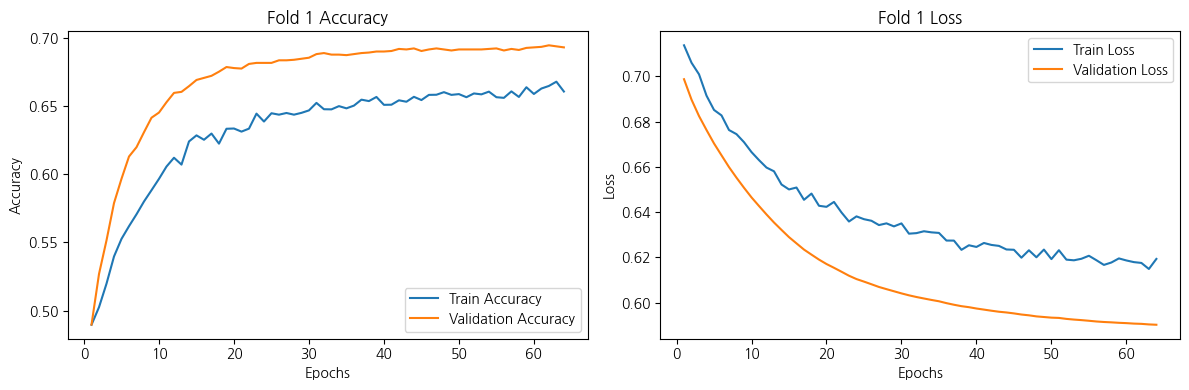

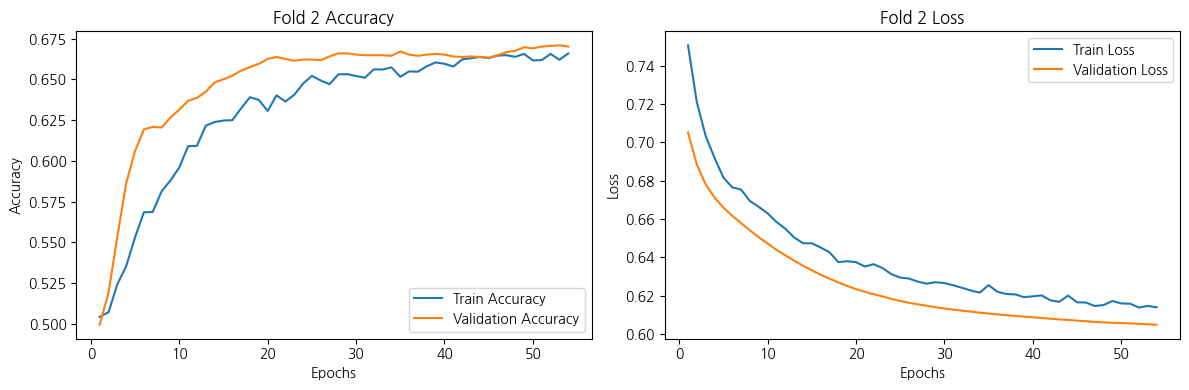

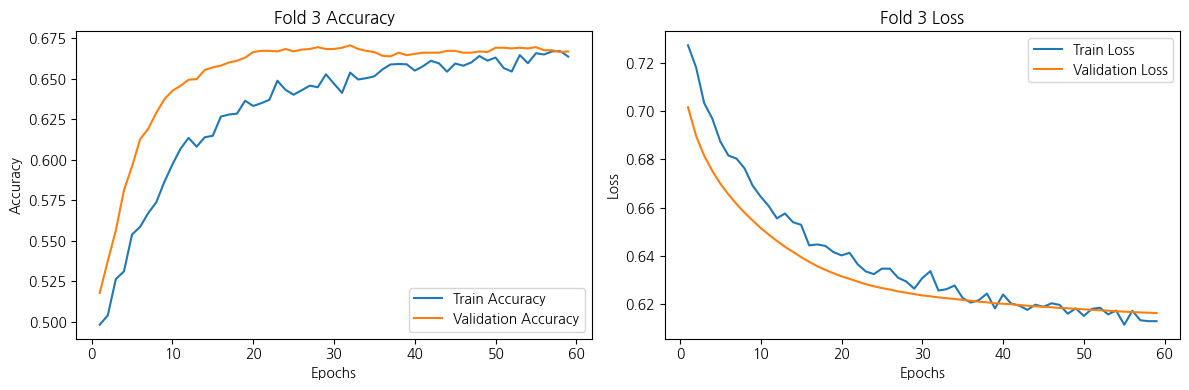

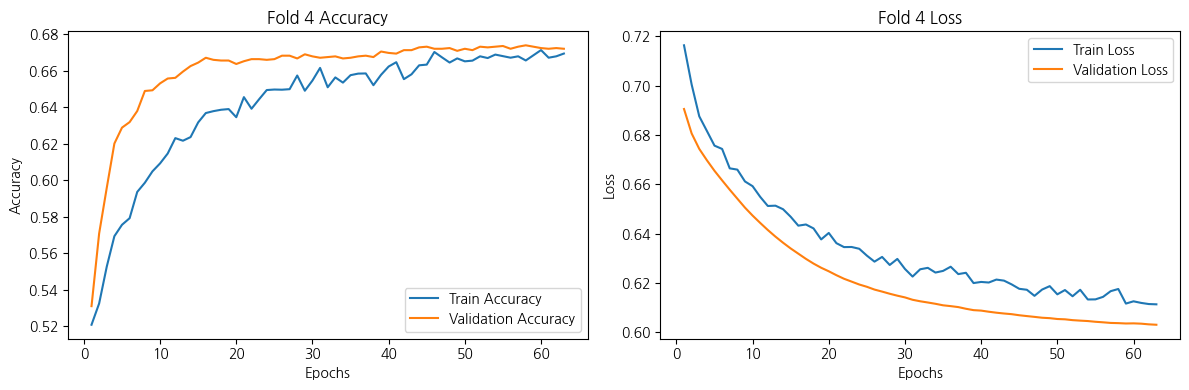

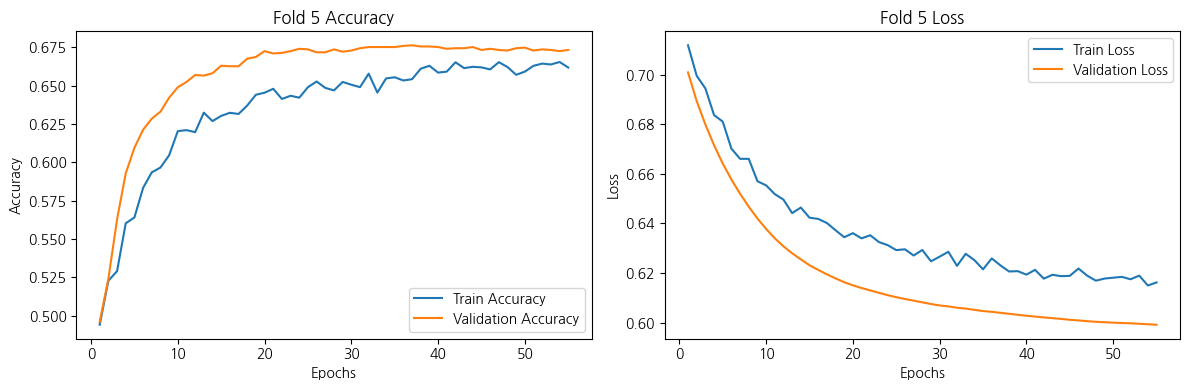

In [135]:
all_history = []
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)
fold = 1
roc_auc_scores = []

for train_index, valid_index in kf.split(X_resampled):
    print(f"Fold{fold} 시작!")
    X_train_fold, X_valid_fold = X_resampled[train_index], X_resampled[valid_index]
    y_train_fold, y_valid_fold = y_resampled[train_index], y_resampled[valid_index]
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation = "relu", input_shape = (X_train_fold.shape[1],)),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation = "relu"),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation = "relu"),
        tf.keras.layers.Dense(1, activation = "sigmoid")
    ])
    model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
        loss = "binary_crossentropy",
        metrics = ["accuracy"]
    )
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor = "val_loss",
        patience = 5,
        min_delta = 0.001,
        restore_best_weights = True
    )
    history = model.fit(
        X_train_fold, y_train_fold,
        validation_data = (X_valid_fold, y_valid_fold),
        epochs = 100,
        batch_size = 32,
        callbacks = [early_stop],
        verbose = 1
    )
    all_history.append(history.history)
    y_valid_pred = model.predict(X_valid_fold).ravel()
    roc_auc = roc_auc_score(y_valid_fold, y_valid_pred)
    print(f"Fold {fold} ROC-AUC SCORE {roc_auc:.4f}")
    roc_auc_scores.append(roc_auc)
    fold += 1

print(f"교차검증 ROC-AUC SCORE {np.mean(roc_auc_scores):.4f}")

for i, history in enumerate(all_history):
    epochs = range(1, len(history["val_loss"]) + 1)
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["accuracy"], label = "Train Accuracy")
    plt.plot(epochs, history["val_accuracy"], label = "Validation Accuracy")
    plt.title(f"Fold {i + 1} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, history["loss"], label = "Train Loss")
    plt.plot(epochs, history["val_loss"], label = "Validation Loss")
    plt.title(f"Fold {i + 1} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
    

In [136]:
pred = model.predict(test_scaled).ravel()
submission = pd.DataFrame({"UID": uid, "채무 불이행 확률": pred * 100})
submission.to_csv("C:/Users/yunju/OneDrive/바탕 화면/submissions/채무불이행 예측/submission6.csv", index = False)
submission.head()

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step


,UID,채무 불이행 확률
0,TEST_0000,0.0
1,TEST_0001,0.0
2,TEST_0002,0.0
3,TEST_0003,0.0
4,TEST_0004,0.0


<Axes: >

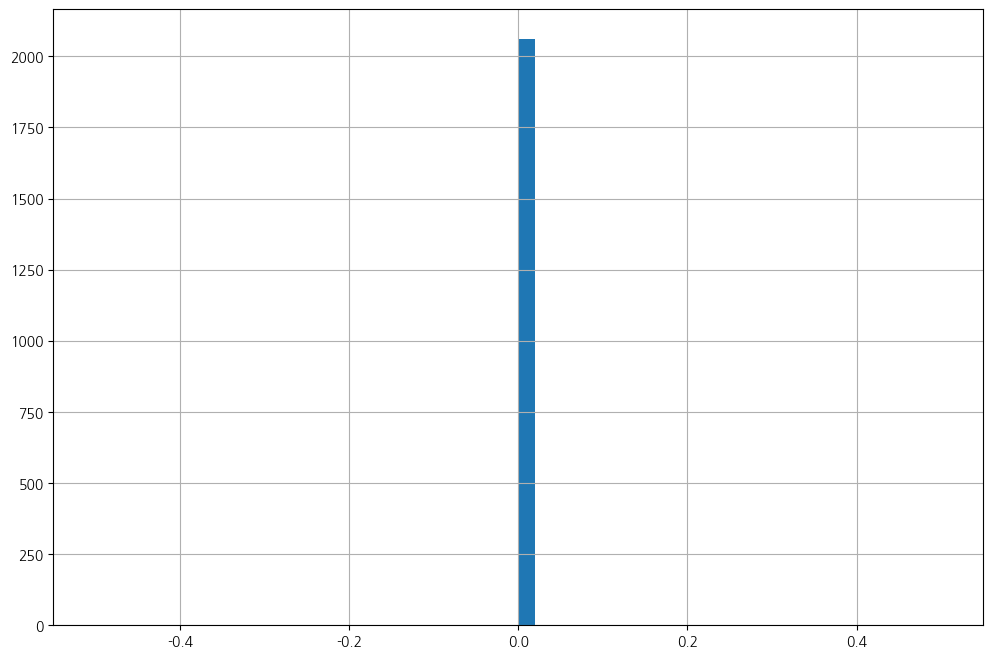

In [137]:
submission["채무 불이행 확률"].hist(figsize = (12,8), bins = 50)